In [1]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt

import pandas as pd  

from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared, Matern, DotProduct, ConstantKernel

In [2]:
# For modifying the size of the fonts, especially in the plots. 
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 'small'
mpl.rcParams['ytick.labelsize'] = 'small'
mpl.rcParams['axes.labelsize'] = 'large'
#mpl.rcParams['xtick.labelsize'] = 'large'
#mpl.rcParams['ytick.labelsize'] = 'large'
#mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['font.size'] = '12'

In [3]:
# Reading data, time series
#df=pd.read_csv('death.txt')
df=pd.read_csv('death_diff_0402.txt')

print(df.shape)
print(df)

(32, 1)
      x
0     0
1     0
2     1
3     1
4     1
5     2
6     5
7     7
8    11
9     7
10   19
11    1
12   78
13   62
14   94
15   53
16  191
17   90
18  207
19  213
20  332
21  397
22  539
23  497
24  839
25  718
26  773
27  844
28  821
29  913
30  748
31  923


In [4]:
# Original Data.
y_ori = np.asarray(df['x'])
print(len(y_ori),'\n',y_ori)

32 
 [  0   0   1   1   1   2   5   7  11   7  19   1  78  62  94  53 191  90
 207 213 332 397 539 497 839 718 773 844 821 913 748 923]


In [5]:
# We select only the only last values, avoiding the first values because has a lot of values.
y_ori = y_ori[-18:]
print(len(y_ori),'\n',y_ori)

18 
 [ 94  53 191  90 207 213 332 397 539 497 839 718 773 844 821 913 748 923]


In [6]:
len_ahead=8
print(len(y_ori))
y= y_ori[0:len(y_ori)-len_ahead]
print(len(y_ori))
print(y)

18
18
[ 94  53 191  90 207 213 332 397 539 497]


In [7]:
real_ahead=y_ori[len(y_ori)-len_ahead:len(y_ori)]
print('real_ahead:', real_ahead)

X= np.atleast_2d(np.arange(len(y))).T
print('X.shape', X.shape)

future=3

sampling_pred=100
x = np.atleast_2d(np.linspace(0, len(y_ori)+future, sampling_pred)).T
print('x.shape: ',x.shape)

x_mean=np.mean(x)
print(x_mean)

real_ahead: [839 718 773 844 821 913 748 923]
X.shape (10, 1)
x.shape:  (100, 1)
10.500000000000002


In [8]:
# Kernel with parameters given in GPML book
k1 = 66.0**2 * RBF(length_scale=67.0)  # long term smooth rising trend
k1bis = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-1, 1e1))
k2 = 2.4**2 * RBF(length_scale=90.0) \
    * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
# medium term irregularity
k3 = 0.36**2 \
    * RationalQuadratic(length_scale=1.2, alpha=0.58) # solo con este va bien
k3bis = 0.40**2 \
    * RationalQuadratic(length_scale=1.2, alpha=0.78)

k4 = 0.18**2 * RBF(length_scale=0.134) \
    + WhiteKernel(noise_level=0.19**2)  # noise terms
k5= RationalQuadratic(length_scale=10.2, alpha=0.78)

k6= 1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0, length_scale_bounds=(0.1, 10.0), periodicity_bounds=(1.0, 10.0))

k7 = 1.0 * Matern(length_scale=10.0, length_scale_bounds=(1e-1, 100.0), nu=1.5)

k8 = ConstantKernel(0.1, (0.01, 10.0)) * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 100.0)) ** 2)

k9 = ConstantKernel(0.1, (0.01, 10.0)) * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2)

k10 = ConstantKernel(0.1, (0.01, 10.0)) * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2) \
      * RationalQuadratic(length_scale=1.2, alpha=0.58)

#

kernels = [x_mean * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           x_mean * RationalQuadratic(length_scale=1.0, alpha=0.1),
           x_mean * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2),
           x_mean * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5)]

kernel_gpml =  k10
print('kernel_gpml', kernel_gpml)

gp = GaussianProcessRegressor(kernel=kernel_gpml, n_restarts_optimizer=10)

kernel_gpml 0.316**2 * DotProduct(sigma_0=1) ** 2 * RationalQuadratic(alpha=0.58, length_scale=1.2)


In [9]:
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

print(gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta))
print('X.shape',X.shape)

2.68**2 * DotProduct(sigma_0=7.59) ** 2 * RationalQuadratic(alpha=0.00263, length_scale=1e-05) -59.13186388179596
X.shape (10, 1)


In [10]:
# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

If you use just a linear kernel in a GP, you're simply doing Bayesian linear regression, and good news! You can do this in time O(N) instead of O(N3).

The linear kernel is not like the others in that it's non-stationary. A stationary covariance function is one that only depends on the relative position of its two inputs, and not on their absolute location. That means that the parameters of the linear kernel are about specifying the origin: 

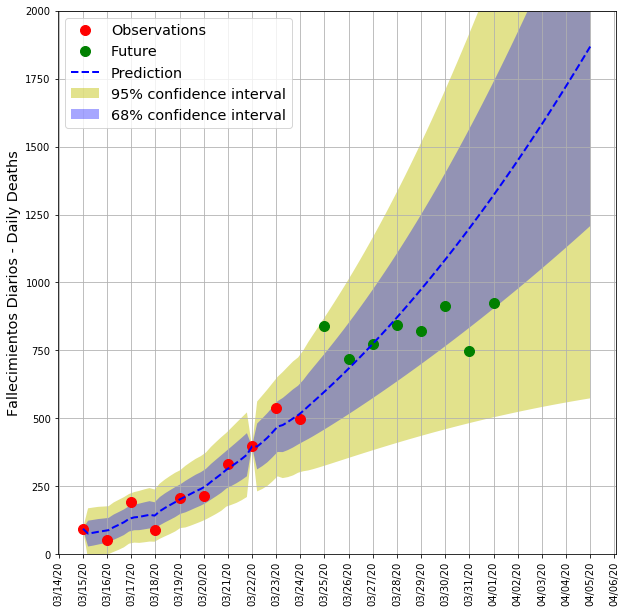

In [11]:
# ----------------------------------------------------------------------
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))# 6,6
plt.figure(1)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
daystart = pd.datetime(2020, 3, 15)
testdaystart = pd.datetime(2020, 3, 25)
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%D"))

pd.date_range(daystart, periods=len(y), freq='D')

plt.plot(pd.date_range(daystart, periods=len(y), freq='D'), y, 'ro', markersize=10,  label='Observations')

plt.plot(pd.date_range(testdaystart, periods=len(real_ahead), freq='D'),real_ahead, 'go', markersize=10, label='Future')

xx=pd.date_range(start='2020/03/15', end='2020/04/05', periods=sampling_pred)

plt.plot(xx, y_pred, 'b--', linewidth=2, label='Prediction')

plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.45, fc='y', ec='None', label='95% confidence interval')

plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_pred - 1.0000 * sigma,
                        (y_pred + 1.0000 * sigma)[::-1]]),
         alpha=.35, fc='b', ec='None', label='68% confidence interval')

plt.grid( axis='both')
plt.legend(loc='upper left')
plt.xticks(rotation='vertical')
plt.ylim(0,2000)
plt.ylabel("Fallecimientos Diarios - Daily Deaths")

plt.savefig('GP_0402_len_ahead_'+str(len_ahead)+'_signa_2_death_diff'+'.jpg')

A partir de este punto se repite el cálculo pero haciendo que el modelo integre todos los datos menos el último. El último es el único pronóstico.

(32, 1)
      x
0     0
1     0
2     1
3     1
4     1
5     2
6     5
7     7
8    11
9     7
10   19
11    1
12   78
13   62
14   94
15   53
16  191
17   90
18  207
19  213
20  332
21  397
22  539
23  497
24  839
25  718
26  773
27  844
28  821
29  913
30  748
31  923
32 
 [  0   0   1   1   1   2   5   7  11   7  19   1  78  62  94  53 191  90
 207 213 332 397 539 497 839 718 773 844 821 913 748 923]
32 
 [  0   0   1   1   1   2   5   7  11   7  19   1  78  62  94  53 191  90
 207 213 332 397 539 497 839 718 773 844 821 913 748 923]
18 
 [ 94  53 191  90 207 213 332 397 539 497 839 718 773 844 821 913 748 923]
18
18
[ 94  53 191  90 207 213 332 397 539 497 839 718 773 844 821 913]
real_ahead: [748 923]
2.06**2 * DotProduct(sigma_0=10) ** 2 * RationalQuadratic(alpha=0.00469, length_scale=0.0293) -98.24180385403284


/home/cardenas/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


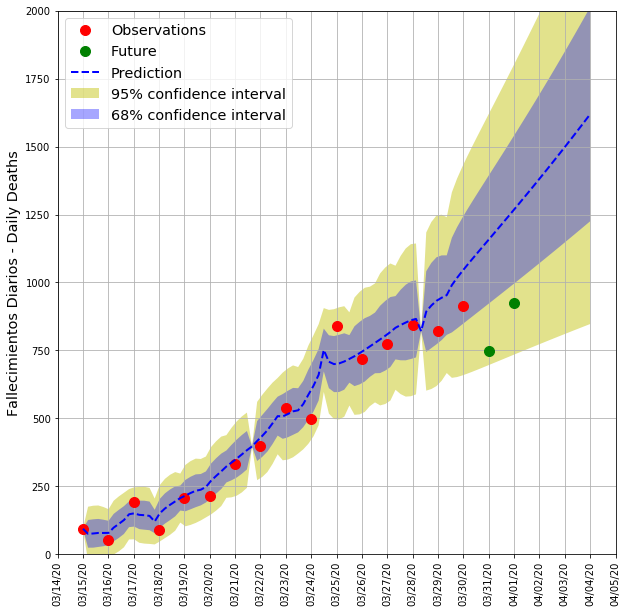

In [15]:
# Reading data, time series
df=pd.read_csv('death_diff_0402.txt')
print(df.shape)
print(df)

# Original Data.
y_ori = np.asarray(df['x'])
print(len(y_ori),'\n',y_ori)

# We select only the only last values, avoiding the first values because has a lot of values.
print(len(y_ori),'\n',y_ori)
y_ori = y_ori[-18:]
print(len(y_ori),'\n',y_ori)

len_ahead=2
print(len(y_ori))

y= y_ori[0:len(y_ori)-len_ahead]
print(len(y_ori))
print(y)

real_ahead=y_ori[len(y_ori)-len_ahead:len(y_ori)]
print('real_ahead:', real_ahead)

X= np.atleast_2d(np.arange(len(y))).T
#print('X.shape', X.shape)

future=3

sampling_pred=100
x = np.atleast_2d(np.linspace(0, len(y_ori)+future, sampling_pred)).T

x_mean=np.mean(x)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

print(gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta))
#print('X.shape',X.shape)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# ----------------------------------------------------------------------
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))# 6,6
plt.figure(1)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
daystart = pd.datetime(2020, 3, 15)
testdaystart = pd.datetime(2020, 3, 31) ## modify for each new day ##
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%D"))

pd.date_range(daystart, periods=len(y), freq='D')

plt.plot(pd.date_range(daystart, periods=len(y), freq='D'), y, 'ro', markersize=10,  label='Observations')

plt.plot(pd.date_range(testdaystart, periods=len(real_ahead), freq='D'),real_ahead, 'go', markersize=10, label='Future')

xx=pd.date_range(start='2020/03/15', end='2020/04/04', periods=sampling_pred)

plt.plot(xx, y_pred, 'b--', linewidth=2, label='Prediction')

plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.45, fc='y', ec='None', label='95% confidence interval')

plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_pred - 1.0000 * sigma,
                        (y_pred + 1.0000 * sigma)[::-1]]),
         alpha=.35, fc='b', ec='None', label='68% confidence interval')

plt.grid( axis='both')
plt.legend(loc='upper left')
plt.xticks(rotation='vertical')
plt.ylim(0,2000)
plt.ylabel("Fallecimientos Diarios - Daily Deaths")

plt.savefig('GP_0402_len_ahead_'+str(len_ahead)+'_signa_2_death_diff'+'.jpg')

(32, 1)
      x
0     0
1     0
2     1
3     1
4     1
5     2
6     5
7     7
8    11
9     7
10   19
11    1
12   78
13   62
14   94
15   53
16  191
17   90
18  207
19  213
20  332
21  397
22  539
23  497
24  839
25  718
26  773
27  844
28  821
29  913
30  748
31  923
32 
 [  0   0   1   1   1   2   5   7  11   7  19   1  78  62  94  53 191  90
 207 213 332 397 539 497 839 718 773 844 821 913 748 923]
32 
 [  0   0   1   1   1   2   5   7  11   7  19   1  78  62  94  53 191  90
 207 213 332 397 539 497 839 718 773 844 821 913 748 923]
18 
 [ 94  53 191  90 207 213 332 397 539 497 839 718 773 844 821 913 748 923]
18
18
[ 94  53 191  90 207 213 332 397 539 497 839 718 773 844 821 913 748]
real_ahead: [923]
1.99**2 * DotProduct(sigma_0=10) ** 2 * RationalQuadratic(alpha=0.00872, length_scale=0.203) -105.60273811730947


/home/cardenas/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


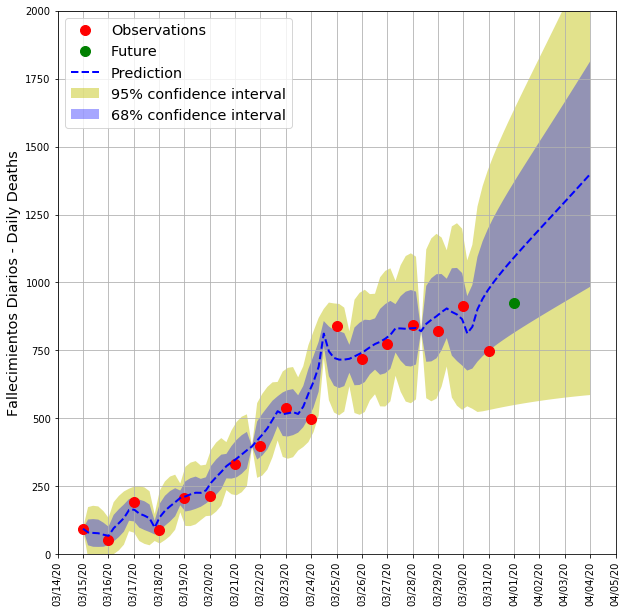

In [13]:
# Reading data, time series
df=pd.read_csv('death_diff_0402.txt')
print(df.shape)
print(df)

# Original Data.
y_ori = np.asarray(df['x'])
print(len(y_ori),'\n',y_ori)

# We select only the only last values, avoiding the first values because has a lot of values.
print(len(y_ori),'\n',y_ori)
y_ori = y_ori[-18:]
print(len(y_ori),'\n',y_ori)

len_ahead=1
print(len(y_ori))

y= y_ori[0:len(y_ori)-len_ahead]
print(len(y_ori))
print(y)

real_ahead=y_ori[len(y_ori)-len_ahead:len(y_ori)]
print('real_ahead:', real_ahead)

X= np.atleast_2d(np.arange(len(y))).T
#print('X.shape', X.shape)

future=3

sampling_pred=100
x = np.atleast_2d(np.linspace(0, len(y_ori)+future, sampling_pred)).T

x_mean=np.mean(x)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

print(gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta))
#print('X.shape',X.shape)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# ----------------------------------------------------------------------
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))# 6,6
plt.figure(1)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
daystart = pd.datetime(2020, 3, 15)
testdaystart = pd.datetime(2020, 4, 1) ## modify for each new day ##
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%D"))

pd.date_range(daystart, periods=len(y), freq='D')

plt.plot(pd.date_range(daystart, periods=len(y), freq='D'), y, 'ro', markersize=10,  label='Observations')

plt.plot(pd.date_range(testdaystart, periods=len(real_ahead), freq='D'),real_ahead, 'go', markersize=10, label='Future')

xx=pd.date_range(start='2020/03/15', end='2020/04/04', periods=sampling_pred)

plt.plot(xx, y_pred, 'b--', linewidth=2, label='Prediction')

plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.45, fc='y', ec='None', label='95% confidence interval')

plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_pred - 1.0000 * sigma,
                        (y_pred + 1.0000 * sigma)[::-1]]),
         alpha=.35, fc='b', ec='None', label='68% confidence interval')

plt.grid( axis='both')
plt.legend(loc='upper left')
plt.xticks(rotation='vertical')
plt.ylim(0,2000)
plt.ylabel("Fallecimientos Diarios - Daily Deaths")

plt.savefig('GP_0402_len_ahead_'+str(len_ahead)+'_signa_2_death_diff'+'.jpg')

(32, 1)
32 
 [  0   0   1   1   1   2   5   7  11   7  19   1  78  62  94  53 191  90
 207 213 332 397 539 497 839 718 773 844 821 913 748 923]
32 
 [  0   0   1   1   1   2   5   7  11   7  19   1  78  62  94  53 191  90
 207 213 332 397 539 497 839 718 773 844 821 913 748 923]
10 
 [539 497 839 718 773 844 821 913 748 923]
10
10
[539 497 839 718 773 844 821 913]
real_ahead: [748 923]
kernel_gpml 2.55**2 + WhiteKernel(noise_level=0.25) + ExpSineSquared(length_scale=0.5, periodicity=1.5) * DotProduct(sigma_0=1) ** 2 * RationalQuadratic(alpha=0.58, length_scale=1.2)


/home/cardenas/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.29199703e+00,  2.67759675e+00, -5.68045491e-10, -2.40094200e+06,
       -7.13675453e-01,  2.05638008e-04, -1.20990544e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 42, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)


316**2 + WhiteKernel(noise_level=2.24e+04) + ExpSineSquared(length_scale=0.00319, periodicity=0.00101) * DotProduct(sigma_0=0.1) ** 2 * RationalQuadratic(alpha=2.88e+03, length_scale=3.74e+03) -55.42027872670987


/home/cardenas/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.35443756e+00,  2.66342437e+00, -6.11786891e-10, -2.57996759e+06,
       -7.82788794e-01,  2.12002820e-04, -1.24676819e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 42, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)


Text(0,0.5,'Fallecimientos Diarios - Daily Deaths')

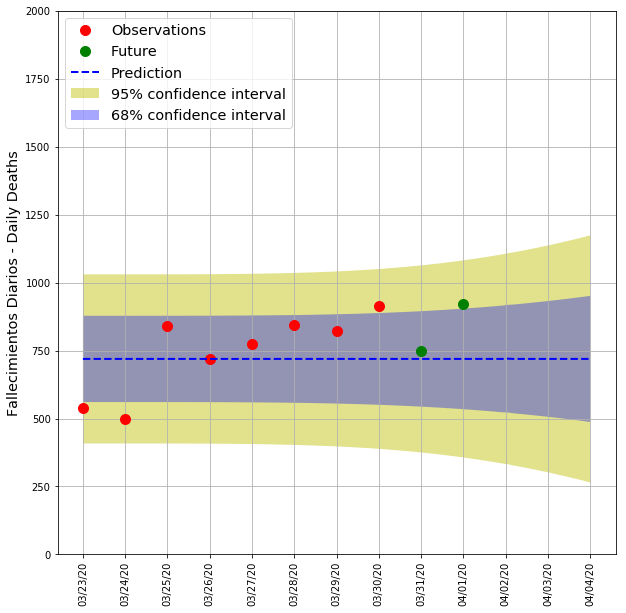

In [52]:
# Reading data, time series
df=pd.read_csv('death_diff_0402.txt')
print(df.shape)
#print(df)

# Original Data.
y_ori = np.asarray(df['x'])
print(len(y_ori),'\n',y_ori)

# We select only the only last values, avoiding the first values because has a lot of values.
print(len(y_ori),'\n',y_ori)
y_ori = y_ori[-10:]
print(len(y_ori),'\n',y_ori)

len_ahead=2
print(len(y_ori))

y= y_ori[0:len(y_ori)-len_ahead]
print(len(y_ori))
print(y)

real_ahead=y_ori[len(y_ori)-len_ahead:len(y_ori)]
print('real_ahead:', real_ahead)

X= np.atleast_2d(np.arange(len(y))).T
#print('X.shape', X.shape)

future=3

sampling_pred=100
x = np.atleast_2d(np.linspace(0, len(y_ori)+future, sampling_pred)).T

x_mean=np.mean(x)

# Contant kernel (for plane data) and some oscilations
kernel_gpml = x_mean + WhiteKernel(noise_level=0.5**2) + ExpSineSquared(length_scale=0.5, periodicity=1.50) \
              *  (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2) \
              * RationalQuadratic(length_scale=1.2, alpha=0.58)
     
print('kernel_gpml', kernel_gpml)

gp = GaussianProcessRegressor(kernel=kernel_gpml, n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

print(gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta))
#print('X.shape',X.shape)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# ----------------------------------------------------------------------
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))# 6,6
plt.figure(1)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
daystart = pd.datetime(2020, 3, 23)
testdaystart = pd.datetime(2020, 3, 31) ## modify for each new day ##
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%D"))

pd.date_range(daystart, periods=len(y), freq='D')

plt.plot(pd.date_range(daystart, periods=len(y), freq='D'), y, 'ro', markersize=10,  label='Observations')

plt.plot(pd.date_range(testdaystart, periods=len(real_ahead), freq='D'),real_ahead, 'go', markersize=10, label='Future')

xx=pd.date_range(start='2020/03/23', end='2020/04/04', periods=sampling_pred)

plt.plot(xx, y_pred, 'b--', linewidth=2, label='Prediction')

plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.45, fc='y', ec='None', label='95% confidence interval')

plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_pred - 1.0000 * sigma,
                        (y_pred + 1.0000 * sigma)[::-1]]),
         alpha=.35, fc='b', ec='None', label='68% confidence interval')

plt.grid( axis='both')
plt.legend(loc='upper left')
plt.xticks(rotation='vertical')
plt.ylim(0,2000)
plt.ylabel("Fallecimientos Diarios - Daily Deaths")